In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
def load_proton_a_images(n=None):
    data_a = pd.read_pickle('../data/proton_images2a.pkl')
    data_b = pd.read_pickle('../data/proton_images2b.pkl')
    data_c = pd.read_pickle('../data/proton_images2c.pkl')

    return np.r_[data_a, data_b, data_c][:n]

def load_neutron_a_images(n=None):
    data_a = pd.read_pickle('../data/neutron_images2a.pkl')
    data_b = pd.read_pickle('../data/neutron_images2b.pkl')
    data_c = pd.read_pickle('../data/neutron_images2c.pkl')

    return np.r_[data_a, data_b, data_c][:n]

def load_particle_data_a(n=None):
    data_a = pd.read_pickle('../data/particles_cond_with_mass2a.pkl')
    data_b = pd.read_pickle('../data/particles_cond_with_mass2b.pkl')
    data_c = pd.read_pickle('../data/particles_cond_with_mass2c.pkl')

    return pd.concat([data_a, data_b, data_c], axis=0)[:n]

In [3]:
N_SAMPLES = None
data_p = load_proton_a_images(N_SAMPLES)
print('Loaded Proton: ',  data_p.shape)

data_n = load_neutron_a_images(N_SAMPLES)
print('Loaded Neutron: ',  data_n.shape)

data_cond = load_particle_data_a(N_SAMPLES)
print('Loaded cond: ',  data_cond.shape)

Loaded Proton:  (511810, 56, 30)
Loaded Neutron:  (511810, 44, 44)
Loaded cond:  (511810, 11)


## Calculate Sum Photons

In [4]:
data_cond.rename(columns={"PhotonSum": "neutron_photon_sum"}, inplace=True)

In [5]:
data_cond.neutron_photon_sum = data_cond.neutron_photon_sum.astype(float)

In [6]:
data_cond['proton_photon_sum'] = np.sum(data_p, axis=(1,2))

In [7]:
data_cond.head()

,Pdg,Energy,Vx,Vy,Vz,Px,Py,Pz,neutron_photon_sum,mass,charge,proton_photon_sum
0,22,513.318,1.454300e-08,3.650510e-08,-0.002731,0.035456,-0.051821,-513.318,291.0,0.000000,0.0,0.0
1,22,1304.340,-1.831820e-05,1.555780e-05,0.050293,-0.509192,0.461106,1304.340,8.0,0.000000,0.0,9.0
2,22,1014.720,-1.831820e-05,1.555780e-05,0.050293,-0.335473,0.256277,1014.720,130.0,0.000000,0.0,0.0
3,-211,325.158,0.000000e+00,0.000000e+00,0.000000,0.269915,-0.081921,325.157,0.0,139.570610,-1.0,5.0
4,2112,3192.380,0.000000e+00,0.000000e+00,0.000000,0.022422,-0.182957,-3192.380,1256.0,939.565413,0.0,16.0


In [8]:
mask = (data_cond.proton_photon_sum >= 20) & (data_cond.neutron_photon_sum >= 20)
indecies = data_cond[mask].index
print(indecies)

Int64Index([     9,     19,     40,     44,     80,     94,    136,    145,
               150,    154,
            ...
            203237, 203279, 203303, 203318, 203323, 203326, 203328, 203339,
            203352, 203353],
           dtype='int64', length=32951)


In [17]:
data_p = data_p[mask]

## Filter Photon Sum

(32951, 56, 30) (32951, 44, 44) (32951, 12)
Min proton photon sum:  20.0 Min proton photon sum:  20.0


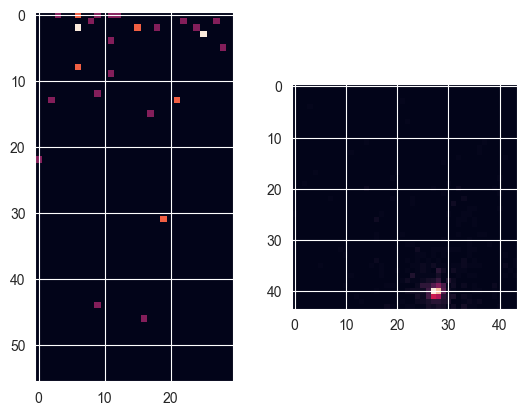

In [43]:
## Filter Photon Sum
def filter_photon_sum(data_p, data_n, data_conditional, min_photon_sum=10):
    """
    Returns particle data and responses of experiments with minimum sum of photons.
    """
    mask = (data_conditional.proton_photon_sum >= min_photon_sum) & (data_conditional.neutron_photon_sum >= min_photon_sum)
    indecies = data_conditional.index[mask]
    print(indecies)
    return data_p[indecies], data_n[indecies], data_conditional[mask].reset_index(drop=True)

MIN_PHOTON_SUM = 20

data_p, data_n, data_cond = filter_photon_sum(data_p, data_n, data_cond, min_photon_sum=MIN_PHOTON_SUM)
print(data_p.shape, data_n.shape, data_cond.shape)
print("Min proton photon sum: ", data_cond.proton_photon_sum.min(),
      "Min proton photon sum: ", data_cond.neutron_photon_sum.min())

fig, ax = plt.subplots(1, 2)
ax[0].imshow(data_p[3], interpolation='none')
ax[1].imshow(data_n[3], interpolation='none')

## Save filtered data

In [45]:
# save conditional data
data_cond.to_pickle(f"../data/data_cond_photonsum_{MIN_PHOTON_SUM}.pkl")

In [20]:
# save proton data
with open(f"../data/data_proton_photonsum_{MIN_PHOTON_SUM}.pkl", 'wb') as f:
    pickle.dump(data_p, f)

## Add padding

Two sizes of images:
- 56 x 30
- 44 x 44

__Goal:__ Add padding to images to transform them to common size: 56 x 44

__Approaches:__
- add padding around the images (center the content)
- add padding to one side of images

In [9]:
from enum import Enum

class PaddingMethod(Enum):
    CENTER = 0
    LEFT_SIDE = 0

In [28]:
def add_padding_56_30(image, method: PaddingMethod = PaddingMethod.CENTER.name):
    """
    Transform image of shape(56, 30) into shape(56, 44).
    :param method: Method of adding padding
    :param image: Image of shape(56, 30)
    :returns: Image of shape(56, 44)
    """
    if method == PaddingMethod.CENTER.name:
        # Add 7 pixels to the left and right side of image
        return np.pad(image,
                      pad_width=((0, 0), (7, 7)),
                      mode='constant', constant_values=0)


def add_padding_44_44(image, method: PaddingMethod = PaddingMethod.CENTER.name):
    """
    Transform image of shape(44, 44) into shape(56, 44).
    :param method: Method of adding padding
    :param image: Image of shape(44, 44)
    :returns: Image of shape(56, 44)
    """
    if method == PaddingMethod.CENTER.name:
        # Add 7 pixels to the top and bottom side of image
        return np.pad(image,
                      pad_width=((6, 6), (0, 0)),
                      mode='constant', constant_values=0)

In [29]:
padded_p = np.array(list(map(add_padding_56_30, data_p)))

In [30]:
padded_n = np.array(list(map(add_padding_44_44, data_n)))

In [31]:
padded_p.shape, padded_n.shape

((32951, 56, 44), (32951, 56, 44))

## Combine images into two channels

Given the padded images, combine them into a single image with 2 channels

### Image results

Text(0.5, 1.0, 'Original neutron image 44x44')

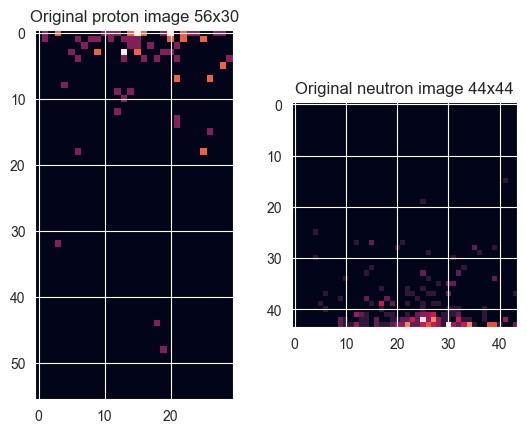

In [154]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(data_p[2], interpolation='none'); ax[0].set_title("Original proton image 56x30")
ax[1].imshow(data_n[2], interpolation='none'); ax[1].set_title("Original neutron image 44x44")

Text(0.5, 1.0, 'Neutron image with padding 56x44')

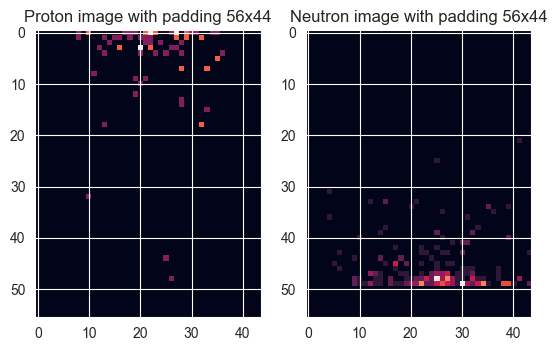

In [155]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(padded_p[2], interpolation='none'); ax[0].set_title("Proton image with padding 56x44")
ax[1].imshow(padded_n[2], interpolation='none'); ax[1].set_title("Neutron image with padding 56x44")

In [1]:
# plt.imshow(data[2], interpolation='none'); plt.title("Combined image for neutron and proton 56x88")

Even though in the combined image the proton response is barely visible, the photonsum from combined image and separate images is equal.

In [161]:
# assert data[0].sum() == (data_p[0].sum() + data_n[0].sum())
# assert data[0].sum() == (padded_p[0].sum() + padded_n[0].sum())

In [160]:
# # get 10 images having most photon sum
# indx = data_cond.apply(lambda x: x.neutron_photon_sum+x.proton_photon_sum, axis=1).sort_values(ascending=False).index
#
# for i, idx in enumerate(indx):
#     plt.imshow(data[idx-1], interpolation='none'); plt.title("Combined image for neutron and proton 56x88")
#     plt.show()
#     if i > 10:
#         break

## Save files

In [34]:
data_cond.to_pickle(f"../data/data_cond_photonsum_{MIN_PHOTON_SUM}.pkl")

In [35]:
with open(f"../data/data_proton_neutron_photonsum_{MIN_PHOTON_SUM}_padding.pkl", 'wb') as f:
    pickle.dump(data, f)

In [287]:
def combine_into_channels_old(data_1, data_2):
    return np.stack((data_1, data_2)).reshape(-1, 56, 44, 2)

In [32]:
def combine_into_channels(data_1, data_2):
    data = np.zeros(shape=(len(data_1), 56, 44, 2))

    data[:,:,:,0] = data_1
    data[:,:,:,1] = data_2
    return data

In [33]:
data = combine_into_channels(padded_p, padded_n)
data.shape

(32951, 56, 44, 2)

In [303]:
# IDX = 1
#
# fig, ax = plt.subplots(2,2)
#
# ax[0][0].imshow(data[IDX][:,:,0])
# ax[0][1].imshow(data[IDX][:,:,1])
#
# ax[1][0].imshow(padded_p[IDX])
# ax[1][1].imshow(padded_n[IDX])